In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-notebook")
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from data.cleaning import get_dataset_from_pickle
from data.eda import get_timerange
from utils import adfuller_test, create_weekly_heatmap


# To fix numpy versioning error
np.float_ = np.float64
from prophet import Prophet
import itertools

# City of Los Angeles: Proposing a Strategy for Optimizing Parking Enforcement Deployment

**Author: Evan Gabrielson**

---

A strategy for improving the efficiency of LADOT's Parking Enforcement division should function to save the city and citizenry of Los Angeles money. From public data published by the City of LA on their [Open Budget Explorer](https://openbudget.lacity.org/#!/year/2023/operating/0/department_name/Transportation/0/program_name/Parking+Enforcement+Services/0/source_fund_name), we can see that full and part-time salaries as well as overtime account for over 99% of allocated funding. While the official number of officers is not published publicly, we can use budget data and Indeed job postings by the City of LA to create a heuristic for the number of Full-Time Officers (FTO) working for the Parking Enforcement division.

$$\text{FTO Salary} = (\$23.00 \text{ per hour}) * (40 \text{ hours per week}) * (52 \text{ weeks per year}) =  \$47,840 \text{ annually}$$
$$\text{Number of FTOs} = \$58,311,479 \text{ budgeted for salaries } / \text{ } \$47,840 \text{ per FTO salary} = 1,218 \text{ FTOs}$$

In [ ]:
fto_salary = 23 * 40 * 52
num_ftos = 58.3e6 // fto_salary
print(f"Number of FTOs: {num_ftos}")


It appears that over **1218 full-time officer units** are working for the LADOT Parking Enforcement division. 

As previously stated, to optimize the City of LA's budget, profits must be maximized per officer deployed in a given region for a given shift. We can use historical parking citation data to understand the distribution of citations (1) spatially, across the various regions of Los Angeles, and (2) temporally, across the different days of the week. The citation density distribution is significant to the City of LA's budget optimization problem because it is __directly proportional to the maximum potential revenue that can be generated by the parking enforcement department__. Once a predictor for this distribution is known, we can better estimate the demand for enforcement officers by region and time to maximize revenue per officer.

In [2]:
# Load timeseries
citations_ts = get_dataset_from_pickle('data/pickle/timeseries.pickle')
citations_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 437770 entries, 2013-12-31 07:00:00 to 2023-12-27 10:00:00
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   district        437770 non-null  category
 1   citation_count  437770 non-null  int64   
dtypes: category(1), int64(1)
memory usage: 7.1 MB


For the sake of the simplicity of this initial study, we will focus on citation data only in the district of Hollywood. We will revisit the other districts in a final modeling stage to ensure district-to-district discrepancies are correctly incorporated in the models and to allow a complete view of the City of LA's potential budget savings.

In [3]:
# Extract Hollywood-specific data
hollywood_ts = citations_ts[citations_ts['district'] == 'Hollywood']['citation_count']
hollywood_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 87555 entries, 2013-12-31 08:00:00 to 2023-12-27 10:00:00
Series name: citation_count
Non-Null Count  Dtype
--------------  -----
87555 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


#### Looking at Hollywood's Mean Weekly Citation Density

The most rudimentary approach to predicting citation density by hour and weekday is to look at an average of the citation density values across the entire timeseries for each combination of hour and weekday. It would be reasonable to assume that even this basic approach could represent a deployment scheme offering already considerable savings for the City of Los Angeles. Later on, we will examine models that take into account week-by-week differences in citation density to further enhance our savings and deployment demand prediction service.

In [ ]:
create_weekly_heatmap(hollywood_ts)

#### Check for stationarity

Before timeseries modeling can begin, we'll use the Dickey-Fuller test for stationarity and isolate districts that are not stationary on a daily basis.

**Aside:** Testing for non-stationarity with Dickey Fuller

It is important for the sake of modeling and regression techniques that our timeseries is stationary. The Dickey Fuller test allows us to determine whether our timeseries is stationary by trying to establish a value for coefficient $\rho$ in the following equation assuming our timeseries is non-stationary:

$$
x_t = \alpha + \rho x_{t-1} + \epsilon_t \quad \text{where } \alpha = \text{drift \& } \epsilon_t = \text{error term}
$$

By the definition of stationarity, we want to determine if the change in our timeseries ($\Delta x_t$) has a tendency to return to some mean. This would only occur if $\rho$ was less than 1.

$$
\Delta x_t = (\rho - 1) x_{t-1} + \epsilon_t
$$

$$
H_0 : \rho = 1 \quad \text{stationary}\\
H_1 : \rho < 1 \quad \text{non stationary}
$$

In [ ]:
# Print (Augmented) Dickey-Fuller test results
adfuller_test(hollywood_ts)

### Basic Model - ARIMA

Let's split the training and test set and get a baseline model that predicts a constant citation count for all future timesteps. We'll use an ARIMA model with 0 autoregressive (AR) terms and 0 moving average (MA) filter terms to find the future citation count.

In [4]:
TRAIN_SPLIT = 0.8
split_index = int(hollywood_ts.shape[0] * TRAIN_SPLIT)
train_ts, test_ts = hollywood_ts.iloc[:split_index], hollywood_ts.iloc[split_index:]

In [5]:
X_train, y_train = train_ts.index, train_ts.values
X_test, y_test = test_ts.index, test_ts.values

In [ ]:
arima = ARIMA(train_ts, order=(0, 0, 0), enforce_invertibility=False, enforce_stationarity=False)
results = arima.fit()
results.summary()

The [Akaike Information Criterion (AIC)](https://iowabiostat.github.io/research-highlights/joe/Cavanaugh_Neath_2019.pdf) value is an estimator of model quality, which when minimized results in the optimal model in terms of simplicity and accuracy. We can compare the AIC value of our Basic ARIMA Model (in this case: 902324) with the AIC value of more advanced modeling techniques to determine whether or not our more advanced models should be preferred.

In [ ]:
results.plot_diagnostics(figsize=(10,10))

In [ ]:
# Plot the trivial model

In [ ]:
# Print RSME and ACF plots

#### SARIMA Model
Capturing seasonality is important, we'll use a 24 hour period to try and pick up any daily seasonality. In order to isolate the best parameters, we'll use the `auto_arima` function to search across autoregressive (AR), differencing (I) and moving average (MA) terms, as well as seasonal components.

In [ ]:
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, and q
pdq = list(itertools.product(p, d, q))

# Basis represents number of periods in a "season" (7*24 = 168 weekly data points)
basis = 24
seasonal_pdq = [(val[0], val[1], val[2], basis) for val in pdq]

# List to store results
results = []

# Grid search for SARIMAX parameters
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            print(f'----Attempting SARIMAX{order} w/ {seasonal_order} seasonality----')
            # SARIMAX Model
            model = sm.tsa.SARIMAX(train_ts, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            # Fit model
            model_fit = model.fit(disp=False, maxiter=200, method='lbfgs')
            
            # Store results in a dictionary
            results.append({
                'p': order[0],
                'd': order[1],
                'q': order[2],
                'P': seasonal_order[0],
                'D': seasonal_order[1],
                'Q': seasonal_order[2],
                's': basis,
                'AIC': model_fit.aic
            })
            
            print(f'SARIMAX{order} - AIC: {model_fit.aic}')
            
        except Exception as e:
            print(f'SARIMAX{order} failed with error: {e}')
            continue

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort results by AIC value
results_df = results_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

# Display the results
print(results_df)


In [16]:
best_params = results_df.iloc[0, :]
best_order = list(results_df.iloc[0, :3])
best_seasonal_order = list(results_df.iloc[0, 3:-1])
best_aic = results_df.iloc[0, -1]
print(f"Best SARIMAX Parameters:\n------------------\nOrder: {best_order}\nSeasonal Order: {best_seasonal_order}\nAIC Value: {best_aic}\n")
print(results_df.head(20))
results_df.to_pickle('data/pickle/sarimax_results.pickle')

Best SARIMAX Parameters:
------------------
Order: [1.0, 0.0, 1.0]
Seasonal Order: [1.0, 0.0, 1.0, 24.0]
AIC Value: 819916.5341629891

    p  d  q  P  D  Q   s            AIC
0   1  0  1  1  0  1  24  819916.534163
1   1  0  1  1  1  1  24  820152.401155
2   1  0  1  0  1  1  24  821053.119068
3   1  1  1  1  0  1  24  822758.555582
4   1  1  0  1  0  1  24  823112.130029
5   1  1  1  1  1  1  24  823188.933273
6   1  1  0  1  1  1  24  823594.419614
7   1  1  1  0  1  1  24  823898.174526
8   1  1  0  0  1  1  24  824251.952311
9   0  1  1  1  0  1  24  824322.834263
10  0  1  1  1  1  1  24  824593.407545
11  0  1  1  0  1  1  24  825461.938809
12  1  0  0  1  0  1  24  827867.119720
13  1  0  0  1  1  1  24  827936.361798
14  1  0  1  1  0  0  24  828797.164524
15  1  0  0  0  1  1  24  828997.296342
16  1  1  1  1  0  0  24  831421.588039
17  1  1  0  1  0  0  24  831616.457326
18  0  1  1  1  0  0  24  833024.831511
19  1  0  1  1  1  0  24  834698.055149


In [14]:
best_sarima = SARIMAX(train_ts, order=best_order, seasonal_order=best_seasonal_order, enforce_invertibility=False, enforce_stationarity=False)
results = best_sarima.fit()
results.summary()

/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92347D+00    |proj g|=  9.51527D-02


 This problem is unconstrained.



At iterate    5    f=  5.91013D+00    |proj g|=  1.26795D-01

At iterate   10    f=  5.90851D+00    |proj g|=  7.27371D-03

At iterate   15    f=  5.90085D+00    |proj g|=  1.13406D-01

At iterate   20    f=  5.85345D+00    |proj g|=  3.36863D-02

At iterate   25    f=  5.85280D+00    |proj g|=  3.63585D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   3.636D-06   5.853D+00
  F =   5.8527963434626029     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     citation_count   No. Observations:                70044
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -409953.267
Date:                            Wed, 14 Aug 2024   AIC                         819916.534
Time:                                    10:37:04   BIC                         819962.317
Sample:                                12-31-2013   HQIC                        819930.654
                                     - 12-27-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8530      0.001    727.137      0.000       0.851       0.855
ma.L1         -0.4534      0.002   -205.316      0.000      -0.458      -0.449
ar.S.L24       0.9538      0.000   2254.481      0.000       0.953       0.955
ma.S.L24      -0.7142      0.001   -756.337      0.000      -0.716      -0.712
sigma2      7128.1973      8.528    835.853      0.000    7111.483    7144.912
===================================================================================
Ljung-Box (L1) (Q):                 417.44   Jarque-Bera (JB):           7835888.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             3.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

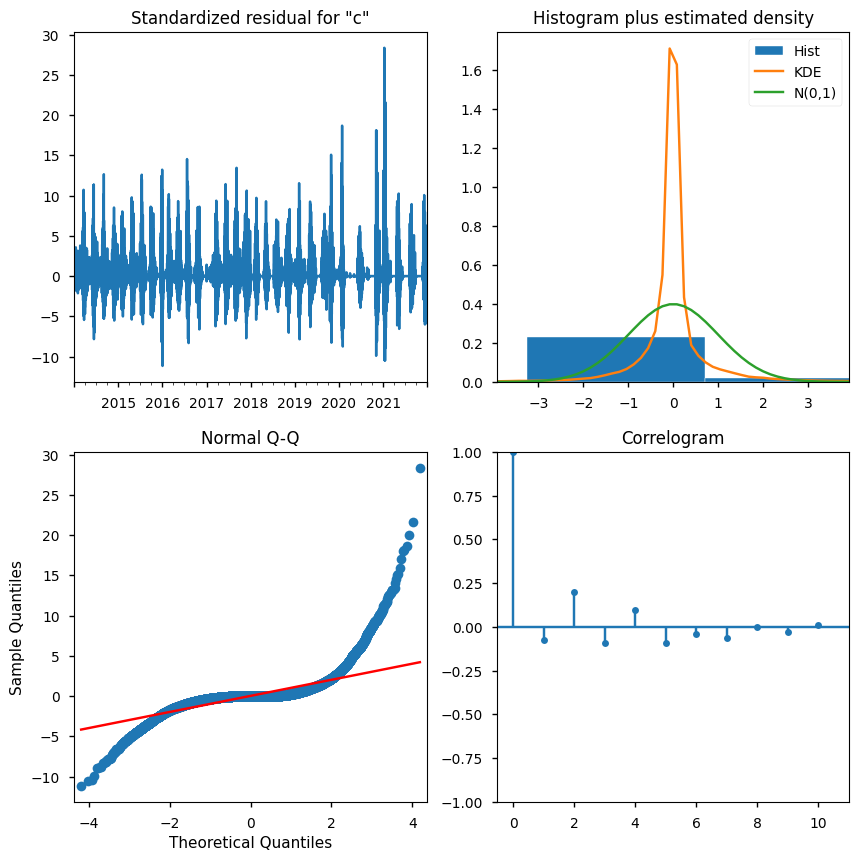

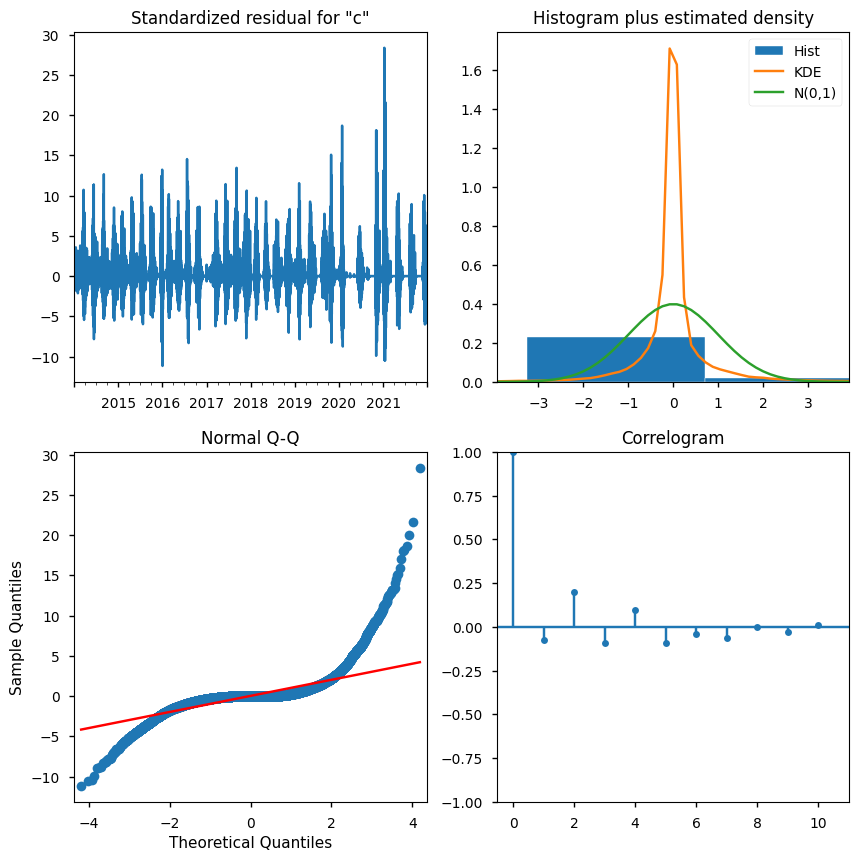

In [17]:
results.plot_diagnostics(figsize=(10,10))

In [43]:
# Get SARIMA predictions
sarimax_pred = results.get_prediction(start=train_ts.index[-1], dynamic=False, full_results=True)
sarimax_pred_intrvl = sarimax_pred.conf_int()

sarimax_forecast = results.get_forecast(steps=test_ts.shape[0]//24)
sarimax_forecast_intrvl = sarimax_forecast.conf_int()

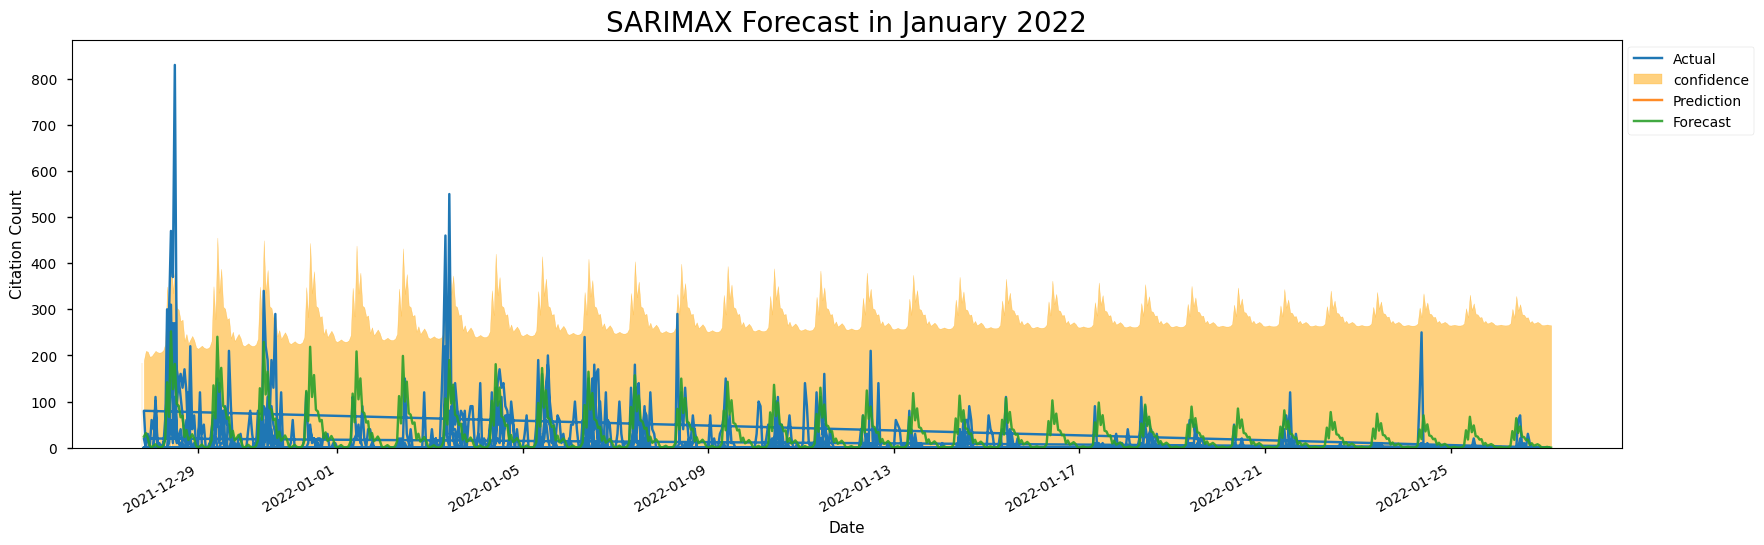

In [56]:
# Plot SARIMA predictions
plt.figure(figsize=(20,6))
ax = get_timerange(citations_ts, sarimax_pred_intrvl.index[0], sarimax_forecast_intrvl.index[-1])['citation_count'].plot(label='Actual')
ax.fill_between(sarimax_pred_intrvl.index, sarimax_pred_intrvl.iloc[:,0], sarimax_pred_intrvl.iloc[:,1], alpha=0.5, color="orange", label='confidence')
ax.fill_between(sarimax_forecast_intrvl.index, sarimax_forecast_intrvl.iloc[:,0], sarimax_forecast_intrvl.iloc[:,1], alpha=0.5, color="orange")

sarimax_pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.9)
sarimax_forecast.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9)
ax.set_ylim(bottom=0)
plt.title('SARIMAX Forecast in January 2022', fontdict={'fontsize':20})
plt.ylabel('Citation Count')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

In [62]:
# Determine RMSE for SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
train_rmse = mean_squared_error(y_true=train_ts, y_pred=sarimax_pred.predicted_mean)
test_rmse = mean_squared_error(y_true=test_ts, y_pred=sarimax_forecast.predicted_mean[train_ts.index[-1]:])

print(f"Training Set RMSE: {train_rmse}")
print(f"Testing Set RMSE: {train_rmse}")

ValueError: Found input variables with inconsistent numbers of samples: [70044, 1]

#### Facebook Prophet

In [23]:
p_train_ts = train_ts.reset_index().rename(columns={'issue_datetime': 'ds', 'citation_count': 'y'})
p_train_ts.head()

,ds,y
0,2013-12-31 08:00:00,80
1,2013-12-31 09:00:00,130
2,2013-12-31 10:00:00,150
3,2013-12-31 11:00:00,0
4,2013-12-31 12:00:00,190


In [24]:
m = Prophet(growth='flat',daily_seasonality=True,weekly_seasonality=True)
m.fit(p_train_ts)

11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:25 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
forecast = m.predict(m.make_future_dataframe(periods=test_ts.shape[0], freq='H'))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
87550,2023-12-27 06:00:00,40.151268,-418.112079,533.392844
87551,2023-12-27 07:00:00,68.567928,-343.838109,544.229642
87552,2023-12-27 08:00:00,106.568920,-359.274134,598.599352
87553,2023-12-27 09:00:00,145.263820,-290.204677,644.330485
87554,2023-12-27 10:00:00,172.485421,-287.431770,667.987654


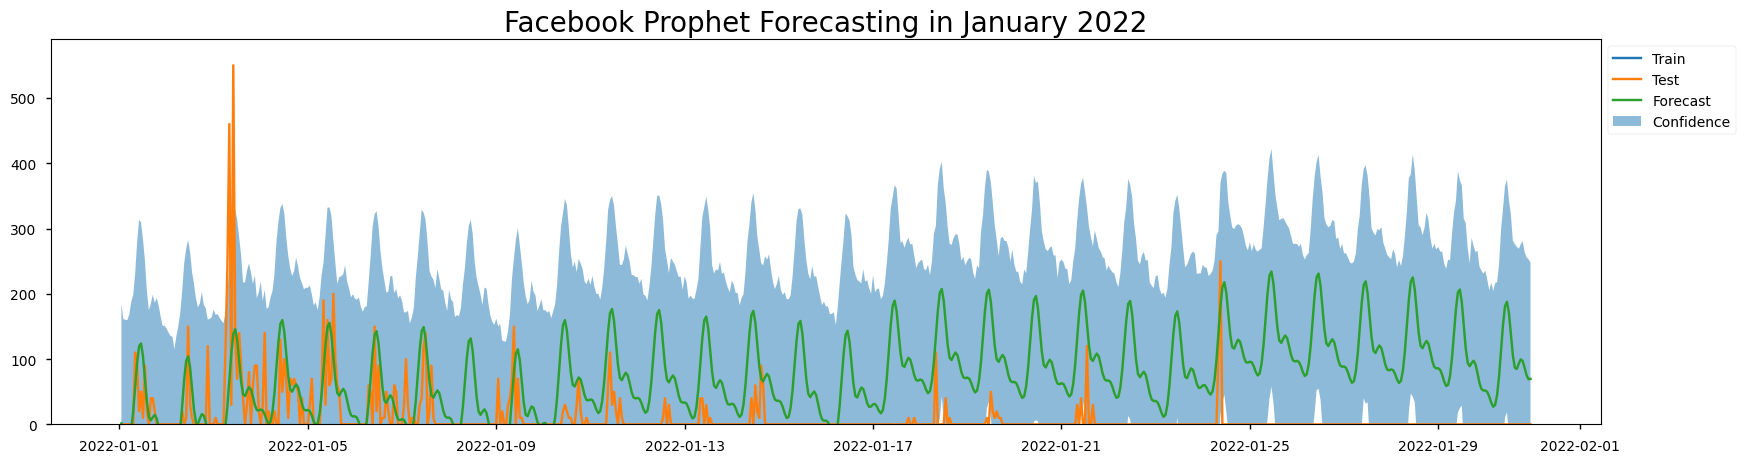

In [60]:
start_date, end_date = '2022-1-1', '2022-1-31'
forecast_ts = forecast.set_index('ds')
train_ts_intrvl = get_timerange(train_ts, start_date, end_date)
test_ts_intrvl = get_timerange(test_ts, start_date, end_date)
forecast_ts_intrvl = get_timerange(forecast_ts, start_date, end_date)

# Plot FB Prophet results
plt.figure(figsize=(20, 5))
plt.plot(train_ts_intrvl, label='Train')
plt.plot(test_ts_intrvl, label='Test')
plt.plot(forecast_ts_intrvl.yhat, label='Forecast')
plt.fill_between(forecast_ts_intrvl.index, forecast_ts_intrvl.yhat_lower, forecast_ts_intrvl.yhat_upper, alpha=0.5, label='Confidence')
plt.title('Facebook Prophet Forecasting in January 2022', fontdict={'fontsize':20})
plt.ylim(bottom=0)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [41]:
# Determine RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
train_rmse = mean_squared_error(y_true=train_ts, y_pred=forecast_ts.yhat[:train_ts.shape[0]])
test_rmse = mean_squared_error(y_true=test_ts, y_pred=forecast_ts.yhat[train_ts.shape[0]:])

print(f"Training Set RMSE: {train_rmse}")
print(f"Testing Set RMSE: {train_rmse}")

Training Set RMSE: 19712.82566458606
Testing Set RMSE: 19712.82566458606
